In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from scipy.stats import pearsonr
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.feature_selection import SelectFromModel


headers = {
    "X-RapidAPI-Key": "cf0bb668d5mshb3cdb48c404d1fcp15cfd4jsn90785f4f4c2c",
    "X-RapidAPI-Host": "football-xg-statistics.p.rapidapi.com"
}

# Evaluating the Efficacy of Expected Goals (xG) as a Statistic in Football: An Analysis of Accuracy and Relevance in the modern game of Football

So, what is xG?

xG is a model that predicts the chances of scoring a goal between 0 and 1 for each shot. It's a model that only factors in the position of the shot taken and yet it is the most popular statistical model in the modern game of football so today we will be looking at whether it's actually a good model or it's inaccurate.

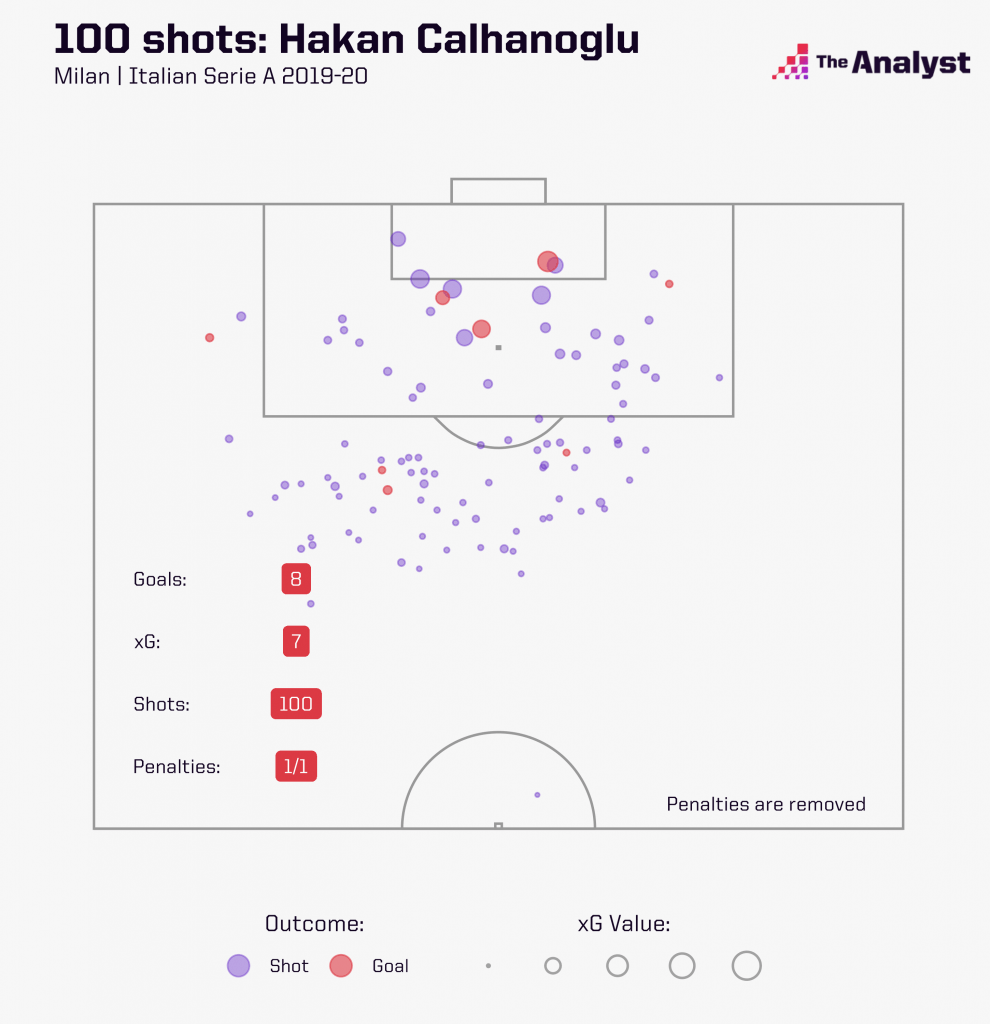

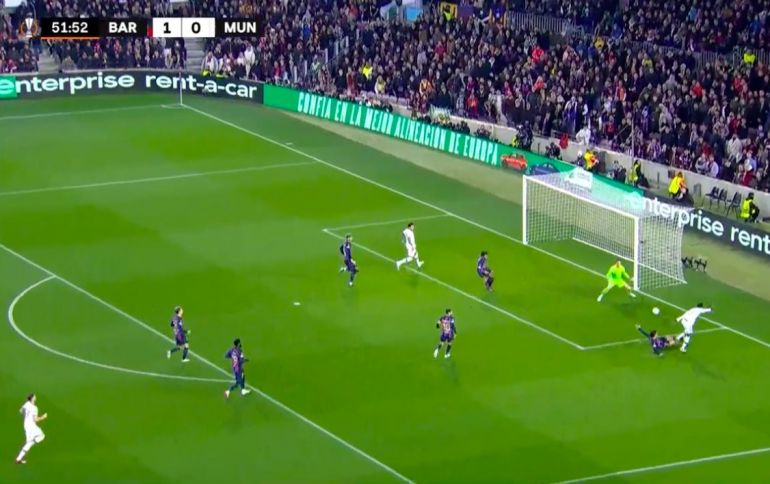

First, we import in the dataset of all goals scored between the 2017/18 season to 2021/22 season of the Premier League. This dataset contains information of every shot taken in every match (A total of 1520  matches in the dataset), the outcome of the shot as well as it's xG and this dataset will be the basis of our data science research topic.

In [3]:
url = "https://football-xg-statistics.p.rapidapi.com/fixtures/124846/"

individualmatch = requests.get(url, headers=headers)
print(individualmatch.json())

response_data = individualmatch.json()['result']

# etracting the relevant information
match_id = response_data['id']
status = response_data['status']
start_time = response_data['startTime']
home_team = response_data['homeTeam']['name']
away_team = response_data['awayTeam']['name']
home_score = response_data['homeScore']['final']
away_score = response_data['awayScore']['final']
xg_home = response_data['xg']['home']
xg_away = response_data['xg']['away']

# creating a DataFrame to store the information
df = pd.DataFrame({
    'MatchID': [match_id],
    'HomeTeam': [home_team],
    'AwayTeam': [away_team],
    'HomeScore': [home_score],
    'AwayScore': [away_score],
    'xGHome': [xg_home],
    'xGAway': [xg_away]
})

events = response_data['events']

# creating lists to store each events data
event_names = []
event_minutes = []
event_types = []
event_xg = []

# now we extract event information
for event in events:
    event_names.append(event['author']['name'])
    event_minutes.append(event['minute'])
    event_types.append(event['type'])
    event_xg.append(event['xg'])

# and now we create the DataFrame for the events
events_df = pd.DataFrame({
    'Name': event_names,
    'Minute': event_minutes,
    'Type': event_types,
    'xG': event_xg
})

print(events_df, "\n")
df

{'result': {'id': 124846, 'status': 'finished', 'startTime': 1628940600, 'updateTime': 1657704036, 'homeTeam': {'id': 6712, 'name': 'Manchester Utd'}, 'awayTeam': {'id': 14846, 'name': 'Leeds'}, 'duration': {'total': 93, 'firstHalf': 46, 'secondHalf': 48}, 'homeScore': {'final': 5, 'firstHalf': 1}, 'awayScore': {'final': 1, 'firstHalf': 0}, 'xg': {'home': 1.73, 'away': 0.58}, 'country': {'id': 291, 'name': 'England'}, 'tournament': {'id': 325, 'name': 'Premier League'}, 'season': {'id': 8202, 'name': '2021/2022'}, 'events': [{'homeScore': 0, 'awayScore': 0, 'minute': 2, 'author': {'id': 6782, 'name': 'S. MCTOMINAY'}, 'teamId': 6712, 'type': 'block', 'xg': 0.026}, {'homeScore': 0, 'awayScore': 0, 'minute': 6, 'author': {'id': 32441, 'name': 'M. GREENWOOD'}, 'teamId': 6712, 'type': 'save', 'xg': 0.016}, {'homeScore': 0, 'awayScore': 0, 'minute': 9, 'author': {'id': 14926, 'name': 'M. KLICH'}, 'teamId': 14846, 'type': 'block', 'xg': 0.021}, {'homeScore': 0, 'awayScore': 0, 'minute': 12, '

,MatchID,HomeTeam,AwayTeam,HomeScore,AwayScore,xGHome,xGAway
0,124846,Manchester Utd,Leeds,5,1,1.73,0.58


## Analysis of the above

So, above, I show you an example of a Match between Manchester United (btw they are my favorite team) vs Leeds and we have 2 DataFrames, one with an overview of the scores against the xG as well as the match ID and another of every one of the 25 shots that were taken in the match, it's minute, outcome and xG. You can see that the goals very clearly have an xG higher than most of those shots that weren't goals

# Now we get to putting every fixture into a DataFrame and ensuring we only keep the data we really need

In [4]:
urls = [
    "https://football-xg-statistics.p.rapidapi.com/seasons/4828/fixtures/", # good
    "https://football-xg-statistics.p.rapidapi.com/seasons/326/fixtures/", # good
    "https://football-xg-statistics.p.rapidapi.com/seasons/2731/fixtures/", # good
    "https://football-xg-statistics.p.rapidapi.com/seasons/5432/fixtures/", # good
    "https://football-xg-statistics.p.rapidapi.com/seasons/8202/fixtures/" # good
]

events_data = []

for url in urls: # iterate through the URLs and get all of the responses
    response = requests.get(url, headers=headers)
    data = response.json()
    fixtures = data['result']

    for fixture in fixtures: # iterate through each fixture
        events = fixture['events']
        game_id = fixture['id']
        home_team = fixture['homeTeam']['name']
        away_team = fixture['awayTeam']['name']

        for event in events: # iterate through each and every event
            event_data = {
                'GameID': game_id,
                'HomeTeam': home_team,
                'AwayTeam': away_team,
                'Name': event['author']['name'],
                'Minute': event['minute'],
                'Type': event['type'],
                'xG': event['xg']
            }
            events_data.append(event_data)

df_events = pd.DataFrame(events_data)

df_events

,GameID,HomeTeam,AwayTeam,Name,Minute,Type,xG
0,85189,West Ham,Everton,M. LANZINI,1,miss,0.010
1,85189,West Ham,Everton,RAMIRO FUNES MORI,3,miss,0.009
2,85189,West Ham,Everton,C. KOUYATÉ,6,block,0.004
3,85189,West Ham,Everton,M. ARNAUTOVIĆ,10,block,0.071
4,85189,West Ham,Everton,M. NOBLE,10,save,0.639
...,...,...,...,...,...,...,...
44829,125746,Brentford,Arsenal,N. PÉPÉ,87,save,0.204
44830,125746,Brentford,Arsenal,PABLO MARÍ,87,miss,0.053
44831,125746,Brentford,Arsenal,A. SAMBI LOKONGA,90,miss,0.012
44832,125746,Brentford,Arsenal,R. NELSON,90,block,0.004


I have identified something that could make xG not a very good model of prediction:

- Own goals holds no xG value, meaning that it would not be accounted for and could stray further from the actual score due to this.

## Now we create a dataframe of each matches score and xG score

In [5]:
url = "https://football-xg-statistics.p.rapidapi.com/seasons/8202/fixtures/"
response = requests.get(url, headers=headers)

url = "https://football-xg-statistics.p.rapidapi.com/seasons/5432/fixtures/"
response1 = requests.get(url, headers=headers)

url = "https://football-xg-statistics.p.rapidapi.com/seasons/2731/fixtures/"
response2 = requests.get(url, headers=headers)

url = "https://football-xg-statistics.p.rapidapi.com/seasons/326/fixtures/"
response3 = requests.get(url, headers=headers)

url = "https://football-xg-statistics.p.rapidapi.com/seasons/4828/fixtures/"
response4 = requests.get(url, headers=headers)

# merging all of the seasons fixtures data
merged_response = response.json()['result'] + response2.json()['result'] + response3.json()['result'] + response4.json()['result']

game_ids = []
status = []
start_times = []
home_teams = []
away_teams = []
home_scores = []
away_scores = []
xg_home = []
xg_away = []

# iterating through every fixture
for fixture in merged_response:
    game_ids.append(fixture['id'])
    status.append(fixture['status'])
    start_times.append(fixture['startTime'])
    home_teams.append(fixture['homeTeam']['name'])
    away_teams.append(fixture['awayTeam']['name'])
    home_scores.append(fixture['homeScore']['final'])
    away_scores.append(fixture['awayScore']['final'])
    xg_home.append(fixture['xg']['home'])
    xg_away.append(fixture['xg']['away'])

# creating the final DataFrame
df = pd.DataFrame({
    'GameID': game_ids,
    'Status': status,
    'StartTime': start_times,
    'HomeTeam': home_teams,
    'AwayTeam': away_teams,
    'HomeScore': home_scores,
    'AwayScore': away_scores,
    'xGHome': xg_home,
    'xGAway': xg_away
})

df

,GameID,Status,StartTime,HomeTeam,AwayTeam,HomeScore,AwayScore,xGHome,xGAway
0,153127,finished,1653231600,Arsenal,Everton,5,1,3.52,1.30
1,153128,finished,1653231600,Brentford,Leeds,1,2,1.27,1.56
2,153129,finished,1653231600,Brighton,West Ham,3,1,2.07,0.27
3,153130,finished,1653231600,Burnley,Newcastle,1,2,1.59,2.27
4,153131,finished,1653231600,Chelsea,Watford,2,1,2.68,1.28
...,...,...,...,...,...,...,...,...,...
1515,84682,finished,1502546400,Everton,Stoke,1,0,0.75,0.49
1516,84683,finished,1502546400,Crystal Palace,Huddersfield,0,3,1.35,1.49
1517,84684,finished,1502546400,Chelsea,Burnley,2,3,1.49,0.97
1518,84680,finished,1502537400,Watford,Liverpool,3,3,2.02,3.41


Now, before I continue, I would like to state some of the many factors that could be taken into account when predicting a shots outcome:

- shot accuracy

- shot power

- goalkeepers position

- a players profile (if he's a defender chances are his shots will be worse than an attackers)

- position of players blocking the goal

- and more...

And yet, despite all the additional factors that could be taken into account xG turns out to be the most popular method of judging a teams attacking output and my entire life I have believed it to be a good method of doing so. So my hypothesis is as follows:

H0 (Null Hypothesis): The xG values of accross the board are within a good accuracy range of the actual goals scored

H1 (Alternative Hypothesis): The xG values of accross the board are not within a good accuracy range of the actual goals scored

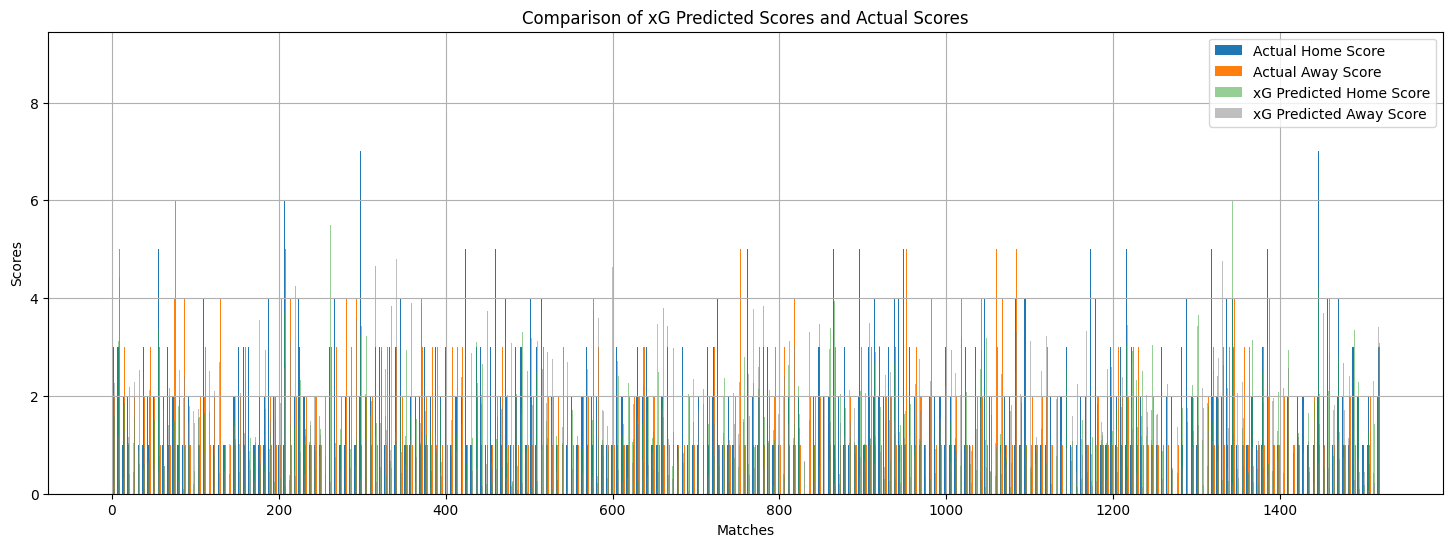

In [6]:
matches = df['GameID']
xg_scores_home = df['xGHome']
xg_scores_away = df['xGAway']
actual_scores_home = df['HomeScore']
actual_scores_away = df['AwayScore']

bar_width = 0.35
index = np.arange(len(matches))

# bar chart
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(index - bar_width/2, actual_scores_home, bar_width, label='Actual Home Score')
ax.bar(index + bar_width/2, actual_scores_away, bar_width, label='Actual Away Score')
ax.bar(index, xg_scores_home, bar_width, alpha=0.5, label='xG Predicted Home Score')
ax.bar(index, xg_scores_away, bar_width, alpha=0.5, label='xG Predicted Away Score', color='grey')

ax.set_xlabel('Matches')
ax.set_ylabel('Scores')
ax.set_title('Comparison of xG Predicted Scores and Actual Scores')
ax.legend()

plt.grid(True)
plt.show()

## Analysis of the bar chart above

Above, we see a bar chart of all the home & away goals scored compared to the xG for each of the 1520 matches across 5 seasons. While it looks like a useless chart that contains too much information, one thing is visually clear. When the score is high, it is unlikely that the xG goes that high too.

# Let's take a closer look below

Over here, we will only look at the first 50 matches

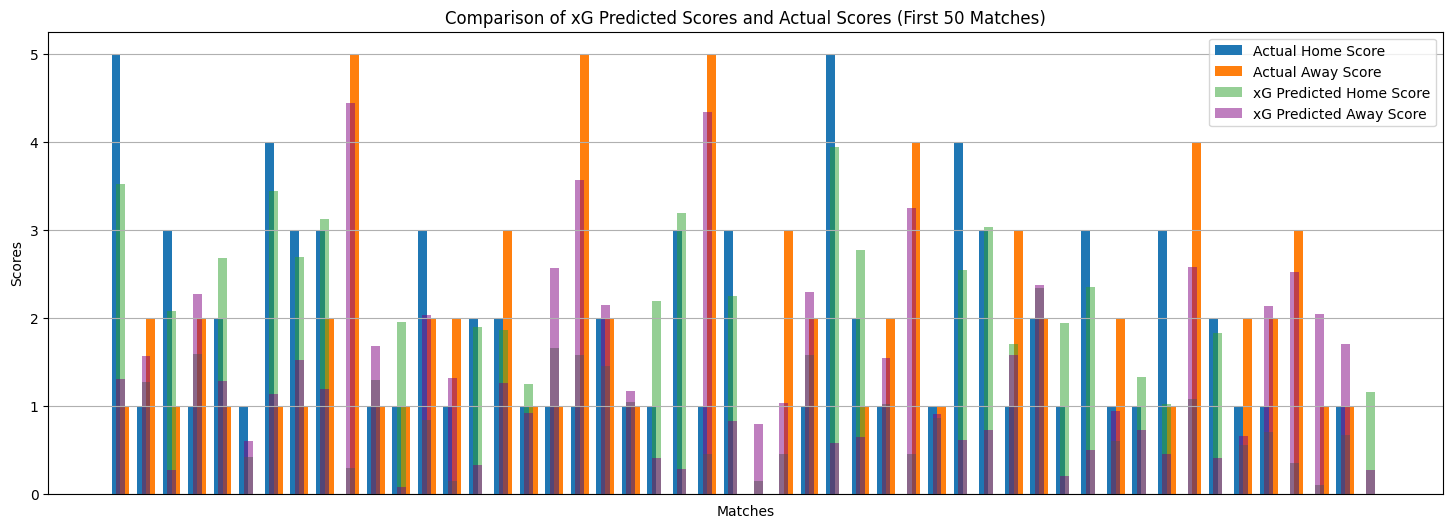

In [7]:
df_first_50 = df.head(50)

xg_scores_home = df_first_50['xGHome']
xg_scores_away = df_first_50['xGAway']
actual_scores_home = df_first_50['HomeScore']
actual_scores_away = df_first_50['AwayScore']

# width
bar_width = 0.35
index = np.arange(len(df_first_50))

# bar chart
fig, ax = plt.subplots(figsize=(18, 6))
ax.bar(index - bar_width/2, actual_scores_home, bar_width, label='Actual Home Score')
ax.bar(index + bar_width/2, actual_scores_away, bar_width, label='Actual Away Score')
ax.bar(index, xg_scores_home, bar_width, alpha=0.5, label='xG Predicted Home Score')
ax.bar(index, xg_scores_away, bar_width, alpha=0.5, label='xG Predicted Away Score', color='purple')

ax.set_xticks([]) # removeing the x-axis labels
ax.set_xlabel('Matches')
ax.set_ylabel('Scores')
ax.set_title('Comparison of xG Predicted Scores and Actual Scores (First 50 Matches)')
ax.legend()

plt.grid(True)
plt.show()

## Some conclusions:

- xG can both overpredict and underpredict.
- In matches where no goals are scored xG ALWAYS overpredicts.
- When rounded up it actually gets better.
- This bar chart is still difficult to read so lets try and further analyse by doing the following:

1) pearson test ✅

2) normal distribution ✅

3) goodness of fit test ✅

4) regression ✅

5) a short analysis on each clubs individual xG ✅

6) Classification 

7) provide a conclusion 

# Pearson correlation coefficient:

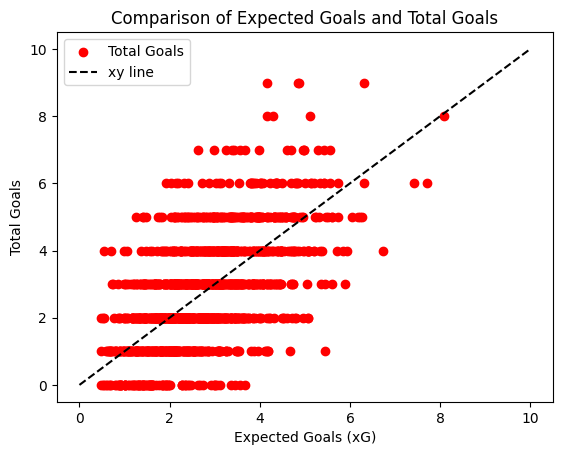

Pearson correlation coefficient: 0.5821527403728829
p-value: 1.3412457849086695e-138


In [12]:
xg_scores_home = df['xGHome']
xg_scores_away = df['xGAway']
actual_scores_home = df['HomeScore']
actual_scores_away = df['AwayScore']

# for the sake of this graph we'll be adding the home and away goals together

total_goals = df['HomeScore'] + df['AwayScore']

plt.scatter(df['xGHome'] + df['xGAway'], total_goals, color='red', label='Total Goals') # plot for total goals

x = np.linspace(0, 10, 100)
y = x
plt.plot(x, y, color='black', linestyle='--', label='xy line') # getting the trendline based on xG values

plt.xlabel('Expected Goals (xG)')
plt.ylabel('Total Goals')
plt.title('Comparison of Expected Goals and Total Goals')
plt.legend()
plt.show()

correlation, p_value = pearsonr(xg_scores_home + xg_scores_away, actual_scores_home + actual_scores_away) # calculating p value and  correlation

print("Pearson correlation coefficient:", correlation)
print("p-value:", p_value)

Now, above, we see that the Pearson correlation coefficient shows a moderate positive corelation of 0.58, this shows us that there is infact a correlation but not anywhere close to a perfect correlation which would have been 1

p-value: 1.3412457849086695e-138
indicating that the observed correlation is statistically significant
this means that it is unlikely to have occurred by chance alone

So far, things are looking just alright. Let's try out the next thing:

## linear regression

Before I show you the results and findings I would like to make some clarifications

## Clarifications:

Linear regression is a statistical technique that predicts the value of unknown data (dependent variable) from related, known data (independent variables)

In this case, xG is the dependant variable that depends on the position of the player. This however, is a fixed variable and there is a mapping of what xG number is the result of which position the shot was taken from so it is useless to apply linear regression on this.

Instead, since I am testing whether or not xG is a good predictor of how many goals are scored in a game, we will act as if xG is the independent variable and the goals scored is the independant variable to see whether there is a relationship strong enough between xG and the actual goals scored.

So, the goals would be the dependant variable that depends on the xG which is the independant variable. If we do find a good R-squared value then it can be stated that this relationship does infact exist!

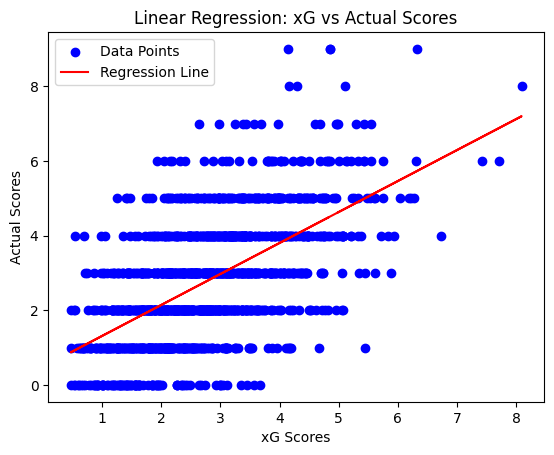

Predicted Scores: [1.3119563  1.7269864  2.14201649 2.55704659 2.97207669 3.38710679
 3.80213689 4.63219709 8.78249809]
R-squared: 0.3389018131236591


In [13]:
df_reg = df.head(1520)

xg_scores = df_reg['xGHome'] + df_reg['xGAway']
actual_scores = df_reg['HomeScore'] + df_reg['AwayScore']

# performing least squares regression
slope, intercept = np.polyfit(xg_scores, actual_scores, 1)

# creating the scatter plot
plt.scatter(xg_scores, actual_scores, color='b', label='Data Points')

plt.plot(xg_scores, slope * xg_scores + intercept, color='r', label='Regression Line') # plotting the regression line

plt.xlabel('xG Scores')
plt.ylabel('Actual Scores')
plt.title('Linear Regression: xG vs Actual Scores')

plt.legend()
plt.show()

# now we make predictions on the actual goals scored based on the xG
xg_values = np.array([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 10.0])  # xG values
predicted_scores = slope * xg_values + intercept # y=mx+c
print("Predicted Scores:", predicted_scores)

# and now to see best fit of the regression line we calculate R squared
predicted_actual_scores = slope * xg_scores + intercept
residuals = actual_scores - predicted_actual_scores
ss_total = np.sum((actual_scores - np.mean(actual_scores))**2)
ss_residual = np.sum(residuals**2)
r_squared = 1 - (ss_residual / ss_total)

print("R-squared:", r_squared)

Now we see some confusing results, the predicted scores when rounded down and up at 0.5, actually give the right score in many cases and yet we get a R-squared value of 0.33. As a refresher, we know that R-squared varies from 0 to 1 and this suggest that only 33.89% of the variation in the actual scores can be explained by linear regression and well the remaining is all caused from other factors.

This is a relatively poor score and while there still is a linear relationship that visible to the eye it's not a very strong one. **This doesn't go to say that there is no relationship but just not a strong linear one.**

let's move on.

## Normal distribution analysis:

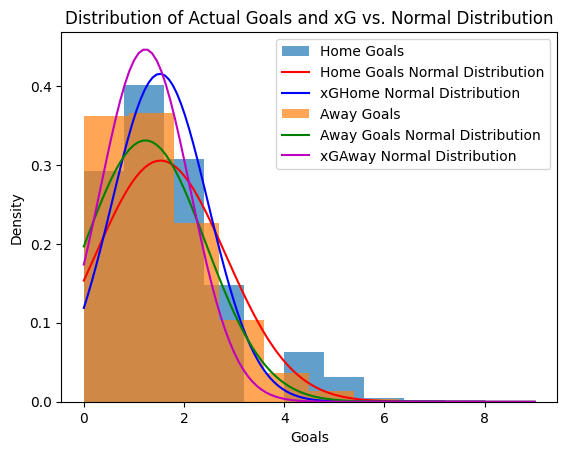

In [14]:
plt.hist(df['HomeScore'], bins=10, density=True, alpha=0.7, label='Home Goals')

mu_home, sigma_home = stats.norm.fit(df['HomeScore'])
x_home = np.linspace(df['HomeScore'].min(), df['HomeScore'].max(), 100)
y_home = stats.norm.pdf(x_home, mu_home, sigma_home) # normal distribution of the home goals scored
plt.plot(x_home, y_home, 'r-', label='Home Goals Normal Distribution') # normal distribution curve for home goals dcored

mu_xg_home, sigma_xg_home = stats.norm.fit(df['xGHome']) #normal distribution to xGHome scored
y_xg_home = stats.norm.pdf(x_home, mu_xg_home, sigma_xg_home)
plt.plot(x_home, y_xg_home, 'b-', label='xGHome Normal Distribution') #normal distribution curve for xGHome


plt.hist(df['AwayScore'], bins=10, density=True, alpha=0.7, label='Away Goals')

# normal distribution for away goals scored
mu_away, sigma_away = stats.norm.fit(df['AwayScore'])
x_away = np.linspace(df['AwayScore'].min(), df['AwayScore'].max(), 100)
y_away = stats.norm.pdf(x_away, mu_away, sigma_away)
plt.plot(x_away, y_away, 'g-', label='Away Goals Normal Distribution') # curve for away goals distribution fitted

#normal distribution to xGAway scored
mu_xg_away, sigma_xg_away = stats.norm.fit(df['xGAway'])
y_xg_away = stats.norm.pdf(x_away, mu_xg_away, sigma_xg_away)
plt.plot(x_away, y_xg_away, 'm-', label='xGAway Normal Distribution') # normal distribution curve for xGAway

plt.xlabel('Goals')
plt.ylabel('Density')
plt.title('Distribution of Actual Goals and xG vs. Normal Distribution')
plt.legend()
plt.show()

## Two things learnt from the normal distribution:

- xG tends to predict a score higher than what is the true score when 0 to 2 goals are scored and then underpredict after that
- the xG and actual goals do line up well in terms of shape and are skewed but the levels differ.

## A short analysis on each clubs individual xG

Now before we go further to do the goodness of fit test I'd like to use a bit of data and facts to see what else xG can tell us.

Here's what we're going to test:
- test if each individual clubs xG and xG conceded (how many goals were predicted to be scored against them) can tell us anythings about their respected clubs.

First we will begin by creating a standings for all the clubs and showing you what their actual goals scored and conceded are vs the xG goals scored and conceded. Also what their total points would've been if the matches were decided by xG and not the actual goals

In [33]:
# dictionary
team_points = {}

# iterating through the data
for index, row in df.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    xg_home = row['xGHome']
    xg_away = row['xGAway']

    # determining the winner based on the xG scores
    if xg_home > xg_away:
        winning_team = home_team
    elif xg_home < xg_away:
        winning_team = away_team
    else:
        winning_team = None

    # assigning points to the winning team in it's own column
    if winning_team:
        team_points[winning_team] = team_points.get(winning_team, 0) + 3

# df
team_stats = pd.DataFrame({'Team': list(team_points.keys()), 'xGPoints': list(team_points.values())})
# we're sorting by xG points here
team_stats = team_stats.sort_values('xGPoints', ascending=False).reset_index(drop=True)

# merge with the original standings DataFrame
standings = pd.merge(team_stats, standings, on='Team', how='left')
# number of games played
games_played = df['HomeTeam'].value_counts() + df['AwayTeam'].value_counts()
games_played = pd.DataFrame({'Team': games_played.index, 'Games Played': games_played.values})
standings = pd.merge(standings, games_played, on='Team', how='left') # merge

standings = standings[['Team', 'Total Points', 'xG Points', 'Goals For', 'xG For', 'Goals Against', 'xG Conceded', 'Goal Difference', 'xG Difference', 'Games Played']]
standings.columns = ['Team', 'Total Points', 'xG Points', 'Goals For', 'xG For', 'Goals Against', 'xG Conceded', 'Goal Difference', 'xG Difference', 'Games Played']
standings

,Team,Total Points,xG Points,Goals For,xG For,Goals Against,xG Conceded,Goal Difference,xG Difference,Games Played
0,Manchester City,372,426,402,389.42,111,107.59,291,281.83,152
1,Liverpool,363,374,352,334.97,119,142.22,233,192.75,152
2,Manchester Utd,271,324,256,258.63,175,174.77,81,83.86,152
3,Chelsea,282,315,270,264.03,164,149.82,106,114.21,152
4,Arsenal,258,294,264,247.06,198,206.41,66,40.65,152
5,Tottenham,278,279,271,248.58,162,166.89,109,81.69,152
6,Leicester,213,243,236,216.72,208,196.89,28,19.83,152
7,Crystal Palace,184,220,177,187.78,204,201.69,-27,-13.91,152
8,Wolves,165,204,136,140.50,132,134.83,4,5.67,114
9,Everton,192,201,188,188.01,226,204.07,-38,-16.06,152


- Note: Some teams haven't played as much as other teams due to being promoted late or being relegated.

Now that we've done that let's start explaining why the results are such. When looking at xG and the stats related to it we can realize some interesting things about each teams playstyle and dominance

- The top 6 have an xG points much higher than that of their actual points, this is because they are teams that play with a dominating and controlling playstyle and tend to get many shots in the game while their opponents focus on getting as many defenders infront of each shot so the ball doesn't get into the goal as it's likely that the opposing team will not get a draw or win unless they defend for dear life. This results in an inflated xG points.


- After the top 6, from 8th place to 13th, there are teams that have xG points and actual points at a similar level, these are teams that play a fairly neutral game, they are teams that can dominate some games against worse teams but also aren't favorites against teams better than them or of their level. They're stable teams and xG does a very good job at predicting these teams final scores as you can see their actual goals scored and conceded and their xG goals scored and conceded are very close to each other. Their consistency is also backed up by the fact that they've played all seasons and have ot been relagated. Another team that belongs in this Category is also Aston Villa but they are further down the table due to being promoted to the premier league later on.


- xG does a terrible job at predicting the teams that have Defensive style of play known as "Park the Bus". These teams include Burnley, Watford FC and Newcastle United. These teams have a playstyle that involves sitting deep in their own box and allowing the opposition lots of posession. This means that a team has many chances to shoot but also that for each chance it's likely that there is a player readily available to block the ball. These teams also rely on scoring on the counter attack where movement is fast and there's little time to think. You can see that these teams overperform their xG points by quite a long way because of this. xG sees every shot without the context of who may or may not be infront of the ball to block the shot hence there's a high xG conceded compared to the actual goals conceded. It's truly amazing how much xG within context can tell you about each team.


- Teams towards the lower end of the table have xG points much lower than their actual points too with very low numbers accross the board. These teams generally rack up draws where they're expected to lose marginally and these are the teams who get relegated at the end of the season

All in all I was quite shocked how well xG did when predicting goal difference for a lot of teams it truly showed how close this model can get. As for predicting points it can be very off due to the fact that Draws generally never exist when calculating xG.

## below are 2 graphs that visualize the standings for xG predicted goals scored and conceded

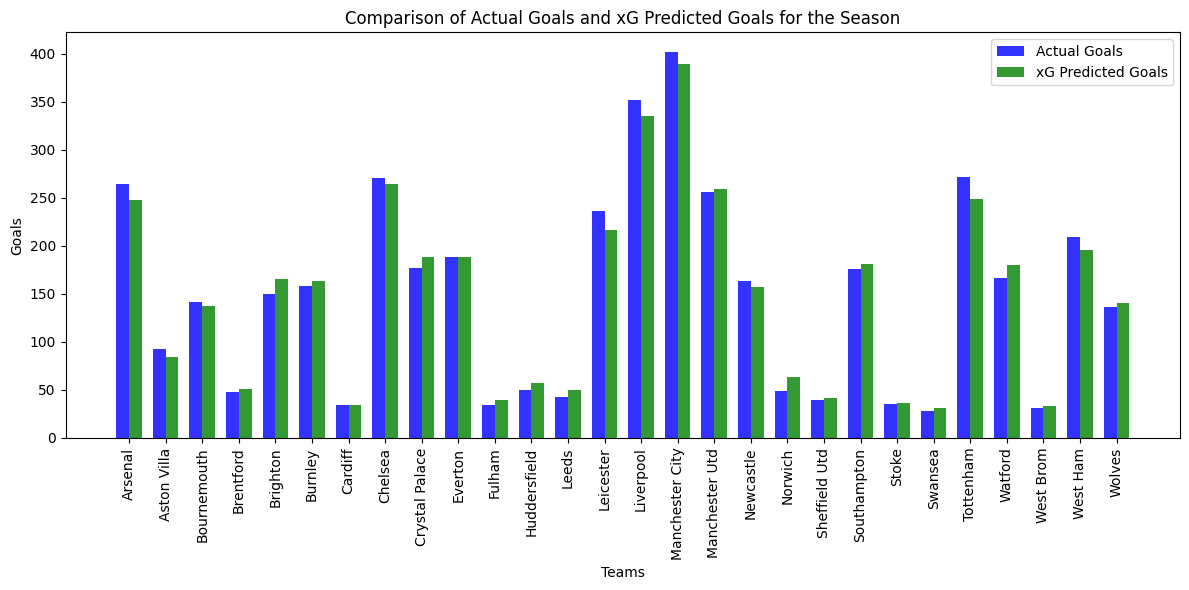

In [34]:
team_goals_actual = df.groupby('HomeTeam')['HomeScore'].sum().add(df.groupby('AwayTeam')['AwayScore'].sum(), fill_value=0)
team_goals_xg = df.groupby('HomeTeam')['xGHome'].sum().add(df.groupby('AwayTeam')['xGAway'].sum(), fill_value=0)

# make it corresponding
teams = team_goals_actual.index
goals_actual = team_goals_actual.values
goals_xg = team_goals_xg.values

# bar chart
fig, ax = plt.subplots(figsize=(12, 6))
index = list(range(len(teams)))
bar_width = 0.35
opacity = 0.8

rects1 = ax.bar(index, goals_actual, bar_width,
                alpha=opacity, color='b', label='Actual Goals')
rects2 = ax.bar([i + bar_width for i in index], goals_xg, bar_width,
                alpha=opacity, color='g', label='xG Predicted Goals')

ax.set_xlabel('Teams')
ax.set_ylabel('Goals')
ax.set_title('Comparison of Actual Goals and xG Predicted Goals for the Season')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(teams, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

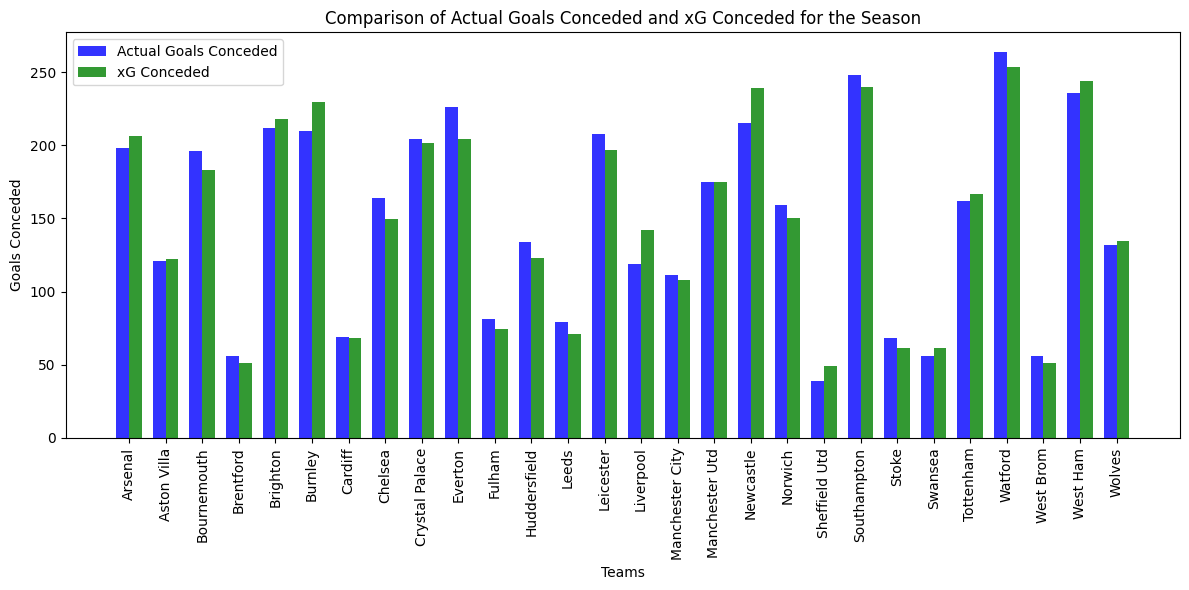

In [35]:
team_goals_conceded_actual = df.groupby('HomeTeam')['AwayScore'].sum().add(df.groupby('AwayTeam')['HomeScore'].sum(), fill_value=0)
team_goals_conceded_xg = df.groupby('HomeTeam')['xGAway'].sum().add(df.groupby('AwayTeam')['xGHome'].sum(), fill_value=0)

teams = team_goals_conceded_actual.index
goals_conceded_actual = team_goals_conceded_actual.values
goals_conceded_xg = team_goals_conceded_xg.values

# bar chart
fig, ax = plt.subplots(figsize=(12, 6))
index = range(len(teams))
bar_width = 0.35
opacity = 0.8

rects1 = ax.bar(index, goals_conceded_actual, bar_width,
                alpha=opacity, color='b', label='Actual Goals Conceded')
rects2 = ax.bar([i + bar_width for i in index], goals_conceded_xg, bar_width,
                alpha=opacity, color='g', label='xG Conceded')

ax.set_xlabel('Teams')
ax.set_ylabel('Goals Conceded')
ax.set_title('Comparison of Actual Goals Conceded and xG Conceded for the Season')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(teams, rotation=90)
ax.legend()
plt.tight_layout()
plt.show()


#  Goodness of fit test: Kolmogorov-Smirnov (K-S) test

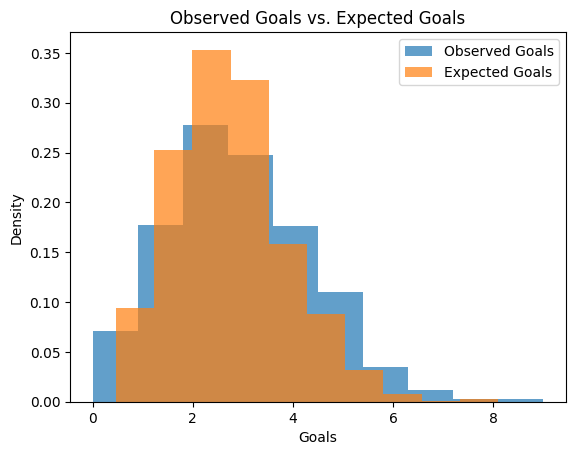

K-S test stat: 0.20526315789473684
p-value: 1.9886859567778918e-28


In [36]:
observed_goals = df['HomeScore'] + df['AwayScore']

expected_goals = df['xGHome'] + df['xGAway']

# visualizing the K-S test
ks_stat, ks_pval = stats.kstest(observed_goals, expected_goals)

plt.hist(observed_goals, bins=10, density=True, alpha=0.7, label='Observed Goals')
plt.hist(expected_goals, bins=10, density=True, alpha=0.7, label='Expected Goals')

plt.xlabel('Goals')
plt.ylabel('Density')
plt.title('Observed Goals vs. Expected Goals')
plt.legend()
plt.show()
print("K-S test stat:", ks_stat)
print("p-value:", ks_pval)

The goodness of fit test that I have chosen for this project is the K-S test statistic which compares the Actual and xG goal distributions.

The K-S test tells us how well 2 distributions fit with each other (how similar they are in shape and size). In this case, the K-S test stat comes in at 0.2 which indicates a very strong similarity between the 2 distributions. This shows a very very strong relationship between xG and the actual goals.

Earlier on we did a linear regression test which gave us a low value of 0.33 and I worried that the relationship shown wasn't one that was close enough but with the goodness of fit test i believe it becomes clear that while it isn't the best linear relationship the relationship is definately a clear one that does exist and not just by chance.

I believe that by now it's become clear that xG is infact a decent model but there's one last thing I would like to test before giving my conclusions on the Hypothesis:

## Random forest classification

In [37]:
df['xGDifference'] = df['xGHome'] - df['xGAway']
df['Outcome'] = np.where(df['HomeScore'] > df['AwayScore'], 'Home Win',
                         np.where(df['HomeScore'] < df['AwayScore'], 'Away Win', 'Draw'))

X = df[['xGDifference']] # these are the features
y = df['Outcome']

# training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# training the random forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# oredicting match outcomes
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5723684210526315


So we have an accuracy of 0.57 (57%) which really isn't the best. At this point we have enough data to make our conclusions and to be honest its a bit "all over the place"

# The Conclusion:

After going through all of the data, plots, graphs and methods to check if xG is a good predictor of Goals scored I have fount enough evidence to reject the null hypothesis. In other words, I have found that xG is not a good enough predictor of match outcomes. 

**However, I also recognize the value of xG in terms of its ability to approximate the expected goal-scoring performance based on solely position which is honestly astounding. Despite its limitations, I do appreciate why xG is widely used in the analysis of football matches and i believe that while it isn't the best method sometimes we need simpler methods that get close enough to the real thing and this is exactly what xG is. It gets so close to achieving greatness while being so simple but it doesn't quite get there.**

*It's a true marvel of a method with a relationship strong enough that it fooled the entire world into thinking it was something that should be standardized.*